In [1]:
import cv2
import numpy as np
import glob
import seaborn as sns
import math
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt

In [2]:
SIFT_method = True

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [3]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('results_img/'+str(count_img)+'ed.jpg', edges)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 100 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [4]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

## Creazione histogramma usando features - creazione NN
accetta in ingresso un vettore con [[img],[classe]]
in uscita mi ritorna kmeans e MLP

In [5]:
keypoints_fixed = []
x1 = 60
y1 = 60

x2 = 80
y2 = 40

x3 = 40
y3 = 40

x4 = 40
y4= 80

x5 = 80
y5 = 80

size = 75

angle = 0

square_size =120
for i in range (1):
    # rappresenta X, Y, size diametro, angle, response, octave, class id
    keypoints_fixed.append(cv2.KeyPoint(x1,y1+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x2,y2+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x3,y3+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x4,y4+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x5,y5+i*square_size,size, angle, 0, 0, -1 ))



In [6]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

def createNN(imgsWithClass, Nclusters):
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()
    else:
        orb = cv2.ORB_create()   
    results = imgsWithClass[0]

    keypoints = []
    descriptors = []
    dico = []
    for img in results:
        if SIFT_method:
            keypoints_temp = keypoints_fixed
            keypoints_temp, descriptors_temp = sift.compute(img, keypoints_temp)
        else:    
            keypoints_temp, descriptors_temp = orb.detectAndCompute(img, None)
        keypoints.append(keypoints_temp)
        descriptors.append(descriptors_temp)
        for d in descriptors_temp:
            dico.append(d)        
    k = Nclusters
    batch_size = 256*4
    print(k)
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)
    
    length = len(results)

    train_index = length - 1 
    train_imgs = results[:train_index]
    validation_imgs = results[train_index:]
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    kmeans.verbose = False
    histo_list = []

    for img in train_imgs:
        if SIFT_method:
            kp = keypoints_fixed
            kp,des = sift.compute(img, kp)
        else:
            kp, des = orb.detectAndCompute(img,None)
        histo = np.zeros(k)
        nkp = np.size(kp)

        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

        histo_list.append(histo)
    #creo X_train e Y_train
    X_train = np.array(histo_list)  
    Y_train = imgsWithClass[1][:train_index]
    
    
    return histo_list,kmeans
    #return kmeans, mlp, val_result

Creo funzione per testare immagini sulla NN trovata

In [7]:
def testNN(img_test,border,pcs,Nclusters):
    img = cutWorkSpace(img_test,border)
    imgs = divideImage(img,pcs)
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create(nfeatures)
    else:
        orb = cv2.ORB_create()   

    k = Nclusters
    results = []
    for img in imgs:
        if SIFT_method:
            kp = keypoints_fixed
            kp, des = sift.compute(img, kp)
        else:
            kp, des = orb.detectAndCompute(img,None)
            
        x = np.zeros(k)
        nkp = np.size(kp)
        for d in des:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp #ottengo vettore normalizzato da kmeans
        t = []
        t.append(x)
        results.append(model.predict(t))

        
    return results

In [58]:
scelta = 120

if scelta == 70:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'
    contamination_N = 6/79.

if scelta == 100:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
    contamination_N = 6/107.
if scelta == 120:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'
    contamination_N = 6/126.

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'

pezziXimmagine = 17
border = 60
Nclusters = 50
nfeatures = 100
#
#

pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v1/*.tif'

results = []
img_results = []
list_paths = []

temp = '/Users/leonardoaggio/Desktop/Dataset/Dataset/SectionScarti/*.tif'



list_paths_scarti = glob.glob(temp)
results += [1] * len(glob.glob(temp))

list_paths = glob.glob(pathBuoni) 
results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine

#list_paths += glob.glob(pathFS)
#results += [0] * len(glob.glob(pathFS)) * pezziXimmagine


#list_paths += glob.glob(pathBuoniVal) 
#results += [0] * len(glob.glob(pathBuoniVal)) * pezziXimmagine

#list_paths += glob.glob(pathFSVal)
#results += [0] * len(glob.glob(pathFSVal)) * pezziXimmagine

#list_paths += glob.glob(pathScartiVal)
#results += [1] * len(glob.glob(pathScartiVal)) * pezziXimmagine


for img_path in list_paths_scarti:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(img)
    #plt.show()
    img_results.append(img)


#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results += temp2
    j = 0
    for im in temp2:
        #cv2.imwrite('ImgScarte/img'+str(i)+'pzs'+str(j)+'.jpg', im)
        j += 1
    i += 1
    
list_paths = list_paths_scarti + list_paths 


contamination_N = len(list_paths_scarti)/len(list_paths) 

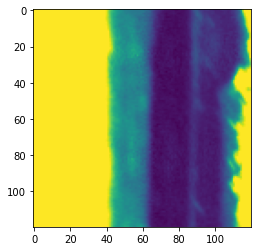

In [59]:
plt.imshow(img_results[0])
plt.show()

In [60]:
#list_paths

In [61]:
imgsWithClass = [img_results,results]


histo,kmeans = createNN(imgsWithClass, Nclusters)

50
Init 1/3 with method: k-means++
Inertia for init 1/3: 13431949.785495
Init 2/3 with method: k-means++
Inertia for init 2/3: 13405318.185191
Init 3/3 with method: k-means++
Inertia for init 3/3: 13757524.152045
Minibatch iteration 1/3700: mean batch inertia: 4501.598355, ewa inertia: 4501.598355 
Minibatch iteration 2/3700: mean batch inertia: 4229.957357, ewa inertia: 4486.757594 
Minibatch iteration 3/3700: mean batch inertia: 4530.304012, ewa inertia: 4489.136697 
Minibatch iteration 4/3700: mean batch inertia: 4445.687712, ewa inertia: 4486.762917 
Minibatch iteration 5/3700: mean batch inertia: 4375.696183, ewa inertia: 4480.694927 
Minibatch iteration 6/3700: mean batch inertia: 4178.072233, ewa inertia: 4464.161521 
Minibatch iteration 7/3700: mean batch inertia: 4263.558281, ewa inertia: 4453.201817 
Minibatch iteration 8/3700: mean batch inertia: 4512.105898, ewa inertia: 4456.419967 
Minibatch iteration 9/3700: mean batch inertia: 4526.801041, ewa inertia: 4460.265148 
Mini

In [62]:
print(len(histo))
print(len(img_results))
print(len(results))

7496
7497
7497


In [63]:
import pandas as pd

print(Nclusters)
cols = []
hist_2 = []
i = 0
for h in histo:
    temp = []
   # temp.append(list_paths[i])
    for el in h:
        temp.append(el)
    temp.append(results[i])
    i += 1
    hist_2.append(temp)
    
#cols.append('name')
for i in range(Nclusters):
    cols.append('F'+str(i+1))

cols.append('R')

df = pd.DataFrame(hist_2 ,columns = cols)



50


In [64]:
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F42,F43,F44,F45,F46,F47,F48,F49,F50,R
0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0
7493,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7494,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [65]:
#sns.boxplot(histo[0])

In [66]:
random_state = np.random.RandomState(42)

In [67]:
col = []

for i in range(Nclusters):
    col.append('F'+str(i+1))

model=IsolationForest(n_estimators=100,max_samples='auto',contamination=contamination_N,random_state=random_state)

model.fit(df[col])

print(model.get_params())

{'bootstrap': False, 'contamination': 0.16314779270633398, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7F853B619490, 'verbose': 0, 'warm_start': False}


In [68]:
df['scores'] = model.decision_function(df[col])

df['anomaly_score'] = model.predict(df[col])

df[df['anomaly_score']==-1]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F44,F45,F46,F47,F48,F49,F50,R,scores,anomaly_score
10,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.009081,-1
12,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.004358,-1
18,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.010010,-1
20,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.006069,-1
21,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.020912,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7456,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.009250,-1
7458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0,-0.009015,-1
7466,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.005733,-1
7485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.019474,-1


In [69]:
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F44,F45,F46,F47,F48,F49,F50,R,scores,anomaly_score
0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.061060,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1,0.058715,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.057873,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.057873,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1,0.043971,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.074356,1
7492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0,-0.019620,-1
7493,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.074356,1
7494,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.074356,1


In [70]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
temp = pathScarti
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    res = testNN(img,border,pezziXimmagine,Nclusters)
    j = 0
    for el in res:
        if el[0]!= 1:
            j +=1
    print(j)
    if j ==0 :
        i += 1
print(res)
print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))



2
3
4
3
5
3
[array([1]), array([1]), array([-1]), array([1]), array([-1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([-1]), array([1]), array([1]), array([1])]
TRAIN scarti
BUONI : 0
Falsi buoni su scarti totali: 0.0


In [71]:
res[0][0]

1

In [72]:
temp = pathScartiVal
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    res = testNN(img,border,pezziXimmagine,Nclusters)
    j = 0
    for el in res:
        if el[0]!= 1:
            j +=1
    print(j)
    if j ==0 :
        i += 1
print('Test scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

4
5
4
Test scarti
BUONI : 0
Falsi buoni su scarti totali: 0.0


In [73]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = pathBuoniVal
#temp = pathScarti
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    res = testNN(img,border,pezziXimmagine,Nclusters)
    j = 0
    for el in res:
        if el[0]!= 1:
            j +=1
    print(j)
    if j !=0 :
        i += 1
print('Test')
print('Scarti : '+ str(i))
print('Falsi scarti su buoni totali: '+ str(i/len(test_path)))

2
2
3
4
2
2
2
2
1
7
3
2
5
1
2
4
3
2
5
2
10
2
3
4
0
1
2
2
3
2
2
5
2
2
3
2
4
2
5
2
1
2
1
5
2
3
2
5
1
2
1
2
3
3
1
3
1
8
3
2
1
3
6
1
3
5
3
1
1
2
2
1
4
6
2
3
4
0
3
Test
Scarti : 77
Falsi scarti su buoni totali: 0.9746835443037974


In [77]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    res = testNN(img,border,pezziXimmagine,Nclusters)
    j = 0
    for el in res:
        if el[0]!= 1:
            j +=1
    print(j)
    if j > 3 :
        print('scarto')
        i += 1
    else:
        print('buono')
print('Test')
print('Scarti : '+ str(i))
print('Falsi scarti su buoni totali: '+ str(i/len(test_path)))

2
buono
2
buono
0
buono
5
scarto
3
buono
2
buono
2
buono
3
buono
5
scarto
2
buono
2
buono
10
scarto
2
buono
4
scarto
2
buono
4
scarto
4
scarto
2
buono
5
scarto
3
buono
1
buono


KeyboardInterrupt: 